In [1]:
# Import libraries
import os
import pandas as pd
import urllib.parse
from dotenv import load_dotenv
from sqlalchemy import create_engine, text
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:

# Load the .env file
load_dotenv()

# Get variables
DB_USERNAME = os.getenv("DB_USERNAME")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST     = os.getenv("DB_HOST")
DB_PORT     = os.getenv("DB_PORT")
DB_NAME     = os.getenv("DB_NAME")


In [3]:
DB_PASSWORD_ENCODED = urllib.parse.quote_plus(DB_PASSWORD)


In [4]:

engine = create_engine(
    f"postgresql+psycopg2://{DB_USERNAME}:{DB_PASSWORD_ENCODED}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)


In [5]:
# Test connection
with engine.connect() as conn:
    result = conn.execute(text("SELECT 1"))
    print(result.fetchone())  # Should print (1,)

(1,)


In [6]:
# what tables exist
with engine.connect() as conn:
    result = conn.execute(text("""
        SELECT table_name 
        FROM information_schema.tables 
        WHERE table_schema = 'public'
    """))
    tables = [row[0] for row in result]
    
if tables:
    print(f"Existing tables: {tables}")
else:
    print("No tables found. Ready to load data.")

Existing tables: ['retail_transactions', 'customer_summary', 'sales_data']


In [7]:

# List files in notebooks folder
notebook_files = os.listdir('notebooks')
print("Files in notebooks folder:")
for file in notebook_files:
    print(f"  - {file}")

# Check for output folder
print("\nChecking for output folder...")
if 'output' in notebook_files:
    output_files = os.listdir('notebooks/output')
    print("Files in notebooks/output:")
    for file in output_files:
        print(f"  - {file}")
else:
    print("No 'output' folder found in notebooks")

Files in notebooks folder:
  - data_processing.py
  - Online Retail.xlsx
  - exploration.ipynb
  - customer_analysis.py
  - __pycache__
  - output
  - analyze_products.py
  - .ipynb_checkpoints
  - utils.py
  - test_pipeline.py
  - main.py

Checking for output folder...
Files in notebooks/output:
  - customer_summary.csv
  - .ipynb_checkpoints
  - cleaned_retail_data.csv


In [8]:

# Load the CSV files
cleaned_data = pd.read_csv('notebooks/output/cleaned_retail_data.csv')
customer_summary = pd.read_csv('notebooks/output/customer_summary.csv')

# Check the cleaned data
print(" CLEANED RETAIL DATA ")
print(f"Shape: {cleaned_data.shape}")  # Shows (rows, columns)
print(f"\nColumn names and types:")
print(cleaned_data.dtypes)
print(f"\nFirst few rows:")
print(cleaned_data.head())

print("\n" + "="*50 + "\n")

# Check the customer summary
print(" CUSTOMER SUMMARY DATA ")
print(f"Shape: {customer_summary.shape}")
print(f"\nColumn names and types:")
print(customer_summary.dtypes)
print(f"\nFirst few rows:")
print(customer_summary.head())

 CLEANED RETAIL DATA 
Shape: (536639, 15)

Column names and types:
InvoiceNo             str
StockCode             str
Description           str
Quantity            int64
InvoiceDate           str
UnitPrice         float64
CustomerID            str
Country               str
Return_Qty          int64
Sale_Qty            int64
Paid_UnitPrice    float64
Is_Free_Item          str
Revenue           float64
Net_Revenue       float64
Total_Items         int64
dtype: object

First few rows:
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice CustomerID         Country  Return_Qty  \
0  

In [9]:
with engine.connect() as conn:
    # Create sales_data table
    print("Creating sales_data table...")
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS SALES_DATA (
            InvoiceNo VARCHAR(20),
            StockCode VARCHAR(50),
            Description TEXT,
            Quantity INTEGER,
            InvoiceDate TIMESTAMP,
            UnitPrice NUMERIC(10,2),
            CustomerID VARCHAR(20),
            Country VARCHAR(100),
            Return_Qty INTEGER,
            Sale_Qty INTEGER,
            Paid_UnitPrice NUMERIC(10,2),
            Is_Free_Item VARCHAR(3),
            Revenue NUMERIC(12,2),
            Net_Revenue NUMERIC(12,2),
            Total_Items INTEGER
        );
    """))
    conn.commit()
    print("✓ sales_data table created")
    
    # Create customer_summary table
    print("\nCreating customer_summary table...")
    conn.execute(text("""
        CREATE TABLE IF NOT EXISTS customer_summary (
            CustomerID VARCHAR(20) PRIMARY KEY,
            Total_Purchases INTEGER,
            Total_Net_Revenue NUMERIC(12,2),
            Total_Sale_Qty INTEGER,
            Total_Return_Qty INTEGER,
            Avg_Order_Value NUMERIC(12,2),
            RecencyDays INTEGER,
            Return_Rate NUMERIC(10,6),
            Net_Qty INTEGER,
            Purchase_Frequency_Monthly NUMERIC(10,2),
            Customer_Value VARCHAR(20)
        );
    """))
    conn.commit()
    print("✓ customer_summary table created")

print("\n Tables created successfully!")

Creating sales_data table...
✓ sales_data table created

Creating customer_summary table...
✓ customer_summary table created

 Tables created successfully!


In [12]:


print("Clearing customer_summary table...")

with engine.connect() as conn:
    conn.execute(text("TRUNCATE TABLE customer_summary"))
    conn.commit()

print(" customer_summary table successfully cleared.")

print("Clearing sales table...")
with engine.connect() as conn:
    conn.execute(text("TRUNCATE TABLE sales_data;"))
    conn.commit()

print(" sales table successfully cleared.")



Clearing customer_summary table...
 customer_summary table successfully cleared.
Clearing sales table...
 sales table successfully cleared.


In [15]:
# Normalize column names FIRST
cleaned_data.columns = cleaned_data.columns.str.lower()

#  Fix the InvoiceDate format before loading
# Currently it's a string, convert to datetime
print("Converting invoicedate to datetime format...")
cleaned_data['invoicedate'] = pd.to_datetime(cleaned_data['invoicedate'])
print("✓ Date conversion complete")

#  Rename columns to match PostgreSQL lowercase
print("\nRenaming columns to lowercase...")
cleaned_data.columns = [col.lower() for col in cleaned_data.columns]
print("New columns:", list(cleaned_data.columns))
print("\nRenaming columns to lowercase...")
customer_summary.columns = [col.lower() for col in customer_summary.columns]
print("New columns:", list(customer_summary.columns))

# Load data into SALES_DATA table
print("\nLoading data into SALES_DATA table...")
cleaned_data.to_sql(
    name='sales_data',           # Table name (lowercase - PostgreSQL converts to lowercase)
    con=engine,                   # Database connection
    if_exists='append',           # 'append' = add data to existing table (don't replace)
    index=False,                  # Don't add pandas index as a column
    chunksize=1000,               # Insert 1000 rows at a time
    method='multi'                # Faster multi-row insert
)
print(f"✓ Loaded {len(cleaned_data):,} rows into SALES_DATA table")

# Load data into customer_summary table
print("\nLoading data into customer_summary table...")
customer_summary.to_sql(
    name='customer_summary',
    con=engine,
    if_exists='append',
    index=False,
    chunksize=1000,
    method='multi'
)
print(f"✓ Loaded {len(customer_summary):,} rows into customer_summary table")

print("\n🎉 All data loaded successfully!")


Converting invoicedate to datetime format...
✓ Date conversion complete

Renaming columns to lowercase...
New columns: ['invoiceno', 'stockcode', 'description', 'quantity', 'invoicedate', 'unitprice', 'customerid', 'country', 'return_qty', 'sale_qty', 'paid_unitprice', 'is_free_item', 'revenue', 'net_revenue', 'total_items']

Renaming columns to lowercase...
New columns: ['customerid', 'total_purchases', 'total_net_revenue', 'total_sale_qty', 'total_return_qty', 'avg_order_value', 'recencydays', 'return_rate', 'net_qty', 'purchase_frequency_monthly', 'customer_value']

Loading data into SALES_DATA table...
✓ Loaded 536,639 rows into SALES_DATA table

Loading data into customer_summary table...
✓ Loaded 4,372 rows into customer_summary table

🎉 All data loaded successfully!


In [16]:
# Quick verification
with engine.connect() as conn:
    # Check counts
    result = conn.execute(text("SELECT COUNT(*) FROM sales_data"))
    sales_count = result.fetchone()[0]
    
    result = conn.execute(text("SELECT COUNT(*) FROM customer_summary"))
    customer_count = result.fetchone()[0]
    
    print(f"✅ Verified: {sales_count:,} sales transactions")
    print(f"✅ Verified: {customer_count:,} unique customers")
    print(f"✅ Average transactions per customer: {sales_count/customer_count:.1f}")

✅ Verified: 531,223 sales transactions
✅ Verified: 4,372 unique customers
✅ Average transactions per customer: 121.5


In [18]:
def run_query(query):
    """Helper function to run SQL and return DataFrame"""
    with engine.connect() as conn:
        return pd.read_sql(query, conn)

# 1. Date range of data
date_range = run_query("""
    SELECT 
        MIN(invoicedate) as first_sale,
        MAX(invoicedate) as last_sale,
        MAX(invoicedate) - MIN(invoicedate) as data_period
    FROM sales_data
""")
print(" Date Range:")
print(date_range)
print()

# 2. Countries with sales
countries = run_query("""
    SELECT country, COUNT(*) as transactions
    FROM sales_data
    GROUP BY country
    ORDER BY transactions DESC
    LIMIT 10
""")
print(" Top 10 Countries by Transactions:")
print(countries)
print()

# 3. Basic financial summary
financial_summary = run_query("""
    SELECT 
        SUM(revenue) as total_revenue,
        SUM(net_revenue) as total_net_revenue,
        SUM(sale_qty) as total_items_sold,
        SUM(return_qty) as total_items_returned,
        COUNT(DISTINCT customerid) as unique_customers,
        COUNT(DISTINCT stockcode) as unique_products
    FROM sales_data
""")
print(" Financial Summary:")
print(financial_summary)

 Date Range:
           first_sale           last_sale       data_period
0 2010-12-01 08:26:00 2011-12-09 12:50:00 373 days 04:24:00

 Top 10 Countries by Transactions:
          country  transactions
0  United Kingdom        485005
1         Germany          9466
2          France          8520
3            EIRE          8179
4           Spain          2512
5     Netherlands          2371
6         Belgium          2069
7     Switzerland          1980
8        Portugal          1495
9       Australia          1257

 Financial Summary:
   total_revenue  total_net_revenue  total_items_sold  total_items_returned  \
0    10587015.73         9705456.04           5619116                481209   

   unique_customers  unique_products  
0              4373             4070  


In [19]:
# Customer segmentation
customer_segments = run_query("""
    SELECT 
        CASE 
            WHEN total_net_revenue >= 1000 THEN 'VIP (>$1K)'
            WHEN total_net_revenue >= 500 THEN 'Premium ($500-$1K)'
            WHEN total_net_revenue >= 100 THEN 'Regular ($100-$500)'
            ELSE 'Small (<$100)'
        END as customer_segment,
        COUNT(*) as customer_count,
        SUM(total_net_revenue) as segment_revenue,
        AVG(total_net_revenue) as avg_revenue_per_customer
    FROM customer_summary
    WHERE total_net_revenue > 0
    GROUP BY customer_segment
    ORDER BY segment_revenue DESC
""")

print(" Customer Segmentation:")
print(customer_segments)

 Customer Segmentation:
      customer_segment  customer_count  segment_revenue  \
0           VIP (>$1K)            1630       7186222.69   
1   Premium ($500-$1K)             907        646135.35   
2  Regular ($100-$500)            1617        448188.12   
3        Small (<$100)             163         11202.40   

   avg_revenue_per_customer  
0               4408.725577  
1                712.387376  
2                277.172616  
3                 68.726380  


In [20]:
# Create monthly_sales first
monthly_sales = run_query("""
    SELECT 
        DATE_TRUNC('month', invoicedate) as month,
        SUM(net_revenue) as monthly_revenue,
        COUNT(*) as transactions,
        SUM(sale_qty) as items_sold
    FROM sales_data
    WHERE net_revenue > 0  -- Only actual sales
    GROUP BY DATE_TRUNC('month', invoicedate)
    ORDER BY month
""")

print("📈 Monthly Sales Data:")
print(monthly_sales.head())
print(f"\nTotal months: {len(monthly_sales)}")

📈 Monthly Sales Data:
       month  monthly_revenue  transactions  items_sold
0 2010-12-01        812278.13         40518      354880
1 2011-01-01        686697.28         33819      385665
2 2011-02-01        520741.02         26642      281972
3 2011-03-01        713846.91         35217      375600
4 2011-04-01        531862.81         28703      307105

Total months: 13


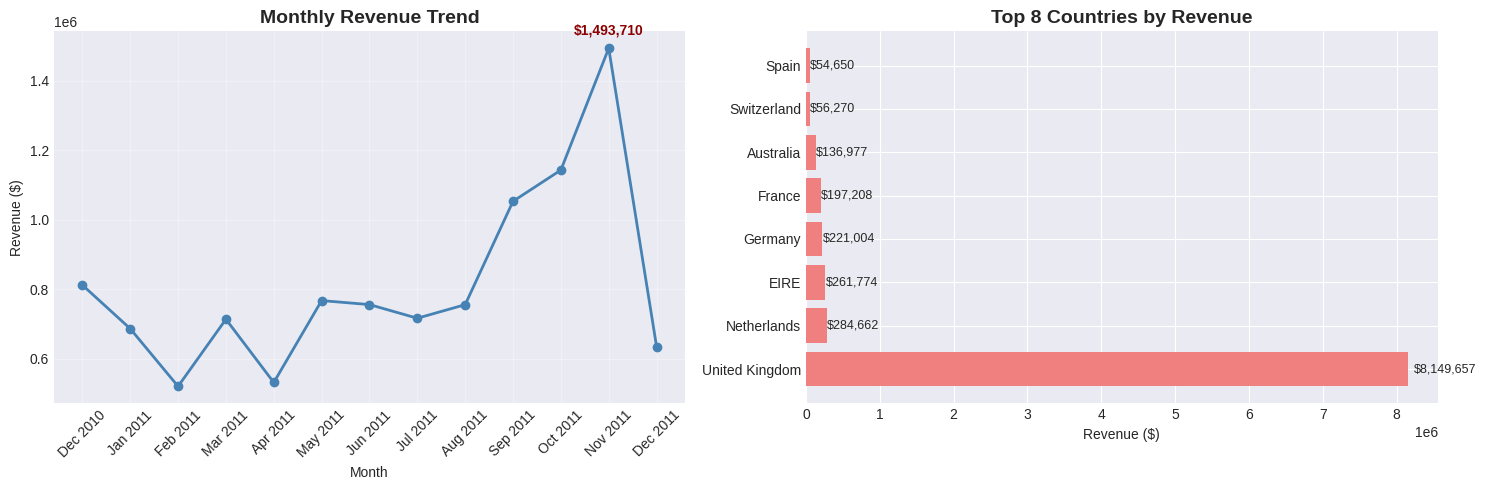


📊 Monthly Sales Data:
month_str  monthly_revenue  transactions
 Dec 2010        812278.13         40518
 Jan 2011        686697.28         33819
 Feb 2011        520741.02         26642
 Mar 2011        713846.91         35217
 Apr 2011        531862.81         28703
 May 2011        767540.80         35694
 Jun 2011        756036.50         35504
 Jul 2011        716751.24         38147
 Aug 2011        755784.70         34013
 Sep 2011       1053278.92         48509
 Oct 2011       1143154.26         57705
 Nov 2011       1493710.07         80652
 Dec 2011        635333.09         24456

🌍 Top Countries Data:
       country    revenue
United Kingdom 8149657.18
   Netherlands  284661.54
          EIRE  261773.96
       Germany  221004.02
        France  197207.54
     Australia  136976.57
   Switzerland   56269.70
         Spain   54649.67


In [21]:


# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Convert month to string for better display (ONLY AFTER monthly_sales exists!)
monthly_sales['month_str'] = monthly_sales['month'].dt.strftime('%b %Y')  # "Jan 2011" format

# Plot 1: Monthly Revenue Line Chart
axes[0].plot(monthly_sales['month_str'], monthly_sales['monthly_revenue'], 
             marker='o', linewidth=2, color='steelblue')
axes[0].set_title('Monthly Revenue Trend', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Revenue ($)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Add value labels on the highest point
max_revenue = monthly_sales['monthly_revenue'].max()
max_month = monthly_sales.loc[monthly_sales['monthly_revenue'] == max_revenue, 'month_str'].iloc[0]
axes[0].annotate(f'${max_revenue:,.0f}', 
                xy=(max_month, max_revenue),
                xytext=(0, 10),
                textcoords='offset points',
                ha='center',
                fontweight='bold',
                color='darkred')

# Plot 2: Get Top Countries Data
top_countries = run_query("""
    SELECT country, SUM(net_revenue) as revenue
    FROM sales_data
    WHERE country != 'Unspecified' AND country IS NOT NULL
    GROUP BY country
    ORDER BY revenue DESC
    LIMIT 8
""")

# Create horizontal bar chart
bars = axes[1].barh(top_countries['country'], top_countries['revenue'], 
                    color='lightcoral')
axes[1].set_title('Top 8 Countries by Revenue', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Revenue ($)')

# Add value labels on bars
for i, (country, revenue) in enumerate(zip(top_countries['country'], 
                                           top_countries['revenue'])):
    axes[1].text(revenue * 1.01, i, f'${revenue:,.0f}', 
                va='center', fontsize=9)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Show the data tables
print("\n📊 Monthly Sales Data:")
print(monthly_sales[['month_str', 'monthly_revenue', 'transactions']].to_string(index=False))

print("\n🌍 Top Countries Data:")
print(top_countries.to_string(index=False))

In [22]:
# Top selling products
top_products = run_query("""
    SELECT 
        description,
        COUNT(*) as transactions,
        SUM(sale_qty) as total_quantity,
        SUM(net_revenue) as total_revenue,
        AVG(unitprice) as avg_price
    FROM sales_data
    WHERE sale_qty > 0
    GROUP BY description
    HAVING SUM(sale_qty) > 100  -- Only products with >100 units sold
    ORDER BY total_revenue DESC
    LIMIT 10
""")

print("🏆 Top 10 Products by Revenue:")
print(top_products[['description', 'total_quantity', 'total_revenue', 'avg_price']])

🏆 Top 10 Products by Revenue:
                          description  total_quantity  total_revenue  \
0                      DOTCOM POSTAGE             708      206248.77   
1            REGENCY CAKESTAND 3 TIER           13799      173044.79   
2         PAPER CRAFT , LITTLE BIRDIE           80995      168469.60   
3  WHITE HANGING HEART T-LIGHT HOLDER           37709      105744.07   
4                       PARTY BUNTING           18237       99173.21   
5             JUMBO BAG RED RETROSPOT           48302       93992.35   
6      MEDIUM CERAMIC TOP STORAGE JAR           78024       81689.67   
7                             POSTAGE            3150       78101.88   
8                              Manual            6816       68530.20   
9                  RABBIT NIGHT LIGHT           30648       66669.23   

    avg_price  
0  291.311822  
1   13.925993  
2    2.080000  
3    3.219168  
4    5.791993  
5    2.485660  
6    1.471134  
7   31.076581  
8  220.300847  
9    2.390594  


In [23]:
# Create a visually appealing dashboard
print("\n" + "="*50)
print(" SALES PERFORMANCE DASHBOARD")
print("="*50)
print()

# Get and display each metric 
dashboard_metrics = [
    ("Total Revenue", "SELECT SUM(net_revenue) FROM sales_data WHERE net_revenue > 0", "currency"),
    (" Avg Order Value", "SELECT AVG(net_revenue) FROM sales_data WHERE net_revenue > 0", "currency"),
    (" Total Customers", "SELECT COUNT(DISTINCT customerid) FROM sales_data", "count"),
    (" Total Transactions", "SELECT COUNT(*) FROM sales_data", "count"),
    ("Return Rate", """
        SELECT 
            CASE WHEN SUM(sale_qty) > 0 
                 THEN (SUM(return_qty) * 100.0 / SUM(sale_qty))
                 ELSE 0 
            END
        FROM sales_data
    """, "percent"),
    # FIXED: Use EXTRACT to get days difference
    ("📅 Data Period", """
        SELECT 
            EXTRACT(DAY FROM (MAX(invoicedate) - MIN(invoicedate))) + 1
        FROM sales_data
    """, "days"),
    ("📈 Avg Daily Revenue", """
        SELECT 
            SUM(net_revenue) / 
            NULLIF(EXTRACT(DAY FROM (MAX(invoicedate) - MIN(invoicedate))) + 1, 0)
        FROM sales_data 
        WHERE net_revenue > 0
    """, "currency"),
    ("🛒 Items per Transaction", "SELECT AVG(total_items) FROM sales_data WHERE total_items > 0", "decimal"),
]

for i, (name, query, format_type) in enumerate(dashboard_metrics):
    try:
        with engine.connect() as conn:
            result = conn.execute(text(query))
            value = result.fetchone()[0] or 0
            
            # Format based on type
            if format_type == "currency":
                display = f"${value:,.2f}"
            elif format_type == "count":
                display = f"{value:,.0f}"
            elif format_type == "percent":
                display = f"{value:.1f}%"
            elif format_type == "days":
                display = f"{int(value)} days"
            elif format_type == "decimal":
                display = f"{value:.1f}"
            else:
                display = str(value)
            
            # Print in columns
            if i % 2 == 0:
                print(f"{name:<25} {display:<20}", end="")
            else:
                print(f"{name:<25} {display}")
    except Exception as e:
        print(f"{name:<25} Error: {str(e)[:50]}...")

if len(dashboard_metrics) % 2 == 1:
    print()  # New line if odd number

print("\n" + "="*50)


 SALES PERFORMANCE DASHBOARD

Total Revenue             $10,587,015.73       Avg Order Value          $20.38
 Total Customers          4,373                Total Transactions       531,223
Return Rate               8.6%                📅 Data Period             374 days
📈 Avg Daily Revenue       $28,307.53          🛒 Items per Transaction   11.5



In [8]:
pip install dash pandas sqlalchemy plotly


  Using cached dash-4.0.0-py3-none-any.whl.metadata (11 kB)
  Using cached plotly-6.5.2-py3-none-any.whl.metadata (8.5 kB)
  Using cached flask-3.1.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached werkzeug-3.1.5-py3-none-any.whl.metadata (4.0 kB)
  Using cached importlib_metadata-8.7.1-py3-none-any.whl.metadata (4.7 kB)
  Using cached retrying-1.4.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached narwhals-2.16.0-py3-none-any.whl.metadata (14 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached click-8.3.1-py3-none-any.whl.metadata (2.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached zipp-3.23.0-py3-none-any.whl.metadata (3.6 kB)
Using cached dash-4.0.0-py3-none-any.whl (7.2 MB)
Using cached plotly-6.5.2-py3-none-any.whl (9.9 MB)
Using cached flask-3.1.2-py3-none-any.whl (103 kB)
Using cached narwhals-2.16.0-py3-none-any.whl (443 kB)
Using cached werkzeug-3.1.5-py3-none-any.whl (225 kB)
Using cached importlib_met